In [1]:
import numpy as np
import torch
print(torch.__version__)

from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

2.0.1+cu118


In [2]:
from utils import eval_model, train, smooth, save_model, load_model, model_params, eval_plots, set_random_seed, eval_model_conf
from dataset_utils import extract_frames

In [ ]:
set_random_seed(420)

In [3]:
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

import os
import shutil

In [4]:
# choose device to be used depending on availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### download dataset and unzip

use preloaded from google drive

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
%%shell
mkdir KTH
mkdir KTH/data
mkdir KTH/data/videos

unzip /content/gdrive/MyDrive/KTH/videos/boxing.zip -d KTH/data/videos
unzip /content/gdrive/MyDrive/KTH/videos/handclapping.zip -d KTH/data/videos
unzip /content/gdrive/MyDrive/KTH/videos/handwaving.zip -d KTH/data/videos
unzip /content/gdrive/MyDrive/KTH/videos/jogging.zip -d KTH/data/videos
unzip /content/gdrive/MyDrive/KTH/videos/running.zip -d KTH/data/videos
unzip /content/gdrive/MyDrive/KTH/videos/walking.zip -d KTH/data/videos

wget -O sequences_list.txt http://www.csc.kth.se/cvap/actions/00sequences.txt


Archive:  /content/gdrive/MyDrive/KTH/videos/boxing.zip
  inflating: KTH/data/videos/person01_boxing_d1_uncomp.avi  
  inflating: KTH/data/videos/person01_boxing_d2_uncomp.avi  
  inflating: KTH/data/videos/person01_boxing_d3_uncomp.avi  
  inflating: KTH/data/videos/person01_boxing_d4_uncomp.avi  
  inflating: KTH/data/videos/person02_boxing_d1_uncomp.avi  
  inflating: KTH/data/videos/person02_boxing_d2_uncomp.avi  
  inflating: KTH/data/videos/person02_boxing_d3_uncomp.avi  
  inflating: KTH/data/videos/person02_boxing_d4_uncomp.avi  
  inflating: KTH/data/videos/person03_boxing_d1_uncomp.avi  
  inflating: KTH/data/videos/person03_boxing_d2_uncomp.avi  
  inflating: KTH/data/videos/person03_boxing_d3_uncomp.avi  
  inflating: KTH/data/videos/person03_boxing_d4_uncomp.avi  
  inflating: KTH/data/videos/person04_boxing_d1_uncomp.avi  
  inflating: KTH/data/videos/person04_boxing_d2_uncomp.avi  
  inflating: KTH/data/videos/person04_boxing_d3_uncomp.avi  
  inflating: KTH/data/videos/

### directly download and unzip

In [ ]:
"""
%%shell
mkdir KTH
mkdir KTH/data
mkdir KTH/data/videos

wget -O KTH/data/videos/boxing.zip http://www.csc.kth.se/cvap/actions/boxing.zip
wget -O KTH/data/videos/handclapping.zip http://www.csc.kth.se/cvap/actions/handclapping.zip
wget -O KTH/data/videos/handwaving.zip http://www.csc.kth.se/cvap/actions/handwaving.zip
wget -O KTH/data/videos/jogging.zip http://www.csc.kth.se/cvap/actions/jogging.zip
wget -O KTH/data/videos/running.zip http://www.csc.kth.se/cvap/actions/running.zip
wget -O KTH/data/videos/walking.zip http://www.csc.kth.se/cvap/actions/walking.zip

unzip KTH/data/videos/boxing.zip -d KTH/data/videos
unzip KTH/data/videos/handclapping.zip -d KTH/data/videos
unzip KTH/data/videos/handwaving.zip -d KTH/data/videos
unzip KTH/data/videos/jogging.zip -d KTH/data/videos
unzip KTH/data/videos/running.zip -d KTH/data/videos
unzip KTH/data/videos/walking.zip -d KTH/data/videos

rm KTH/data/videos/*.zip
"""

'\n%%shell\nmkdir KTH\nmkdir KTH/data\nmkdir KTH/data/videos\n\nwget -O KTH/data/videos/boxing.zip http://www.csc.kth.se/cvap/actions/boxing.zip\nwget -O KTH/data/videos/handclapping.zip http://www.csc.kth.se/cvap/actions/handclapping.zip\nwget -O KTH/data/videos/handwaving.zip http://www.csc.kth.se/cvap/actions/handwaving.zip\nwget -O KTH/data/videos/jogging.zip http://www.csc.kth.se/cvap/actions/jogging.zip\nwget -O KTH/data/videos/running.zip http://www.csc.kth.se/cvap/actions/running.zip\nwget -O KTH/data/videos/walking.zip http://www.csc.kth.se/cvap/actions/walking.zip\n\nunzip KTH/data/videos/boxing.zip -d KTH/data/videos\nunzip KTH/data/videos/handclapping.zip -d KTH/data/videos\nunzip KTH/data/videos/handwaving.zip -d KTH/data/videos\nunzip KTH/data/videos/jogging.zip -d KTH/data/videos\nunzip KTH/data/videos/running.zip -d KTH/data/videos\nunzip KTH/data/videos/walking.zip -d KTH/data/videos\n\nrm KTH/data/videos/*.zip\n'

In [7]:
extract_frames('KTH')

Completed till video :  50
Completed till video :  100
Completed till video :  150
Completed till video :  200
Completed till video :  250
Completed till video :  300
Completed till video :  350
Completed till video :  400
Completed till video :  450
Completed till video :  500
Completed till video :  550
[MESSAGE]	Frames extracted from all videos
[ERROR]:  KTH/data/VALIDATION/person01_boxing_d4_frame_246_370
Completed till video :  50
Completed till video :  100
Completed till video :  150
Completed till video :  200
Completed till video :  250
-----------------------------------------------------------
[ERROR MESSAGE]: 
limits :  ['*missing*']
seq_path :  KTH/data/TRAIN/person13_handclapping_d2_frame_401_523
-----------------------------------------------------------
Completed till video :  300
Completed till video :  350
Completed till video :  400
Completed till video :  450
Completed till video :  500
Completed till video :  550
Completed till video :  600
[ALERT]		Total error cou

### dataset class

In [8]:
import os
import random
from PIL import Image

class KTH_dataset(torch.utils.data.Dataset):

  def __init__(self, DATA_PATH,  transforms = None, mode = 'TRAIN', instance_len = 20):
    self.instances = []
    self.inst_class = []
    self.path = DATA_PATH
    self.mode = mode
    self.transforms = transforms
    self.instance_len = instance_len

    self.mapping = {'boxing':0, 'handclapping':1, 'handwaving':2, 'jogging':3, 'running':4, 'walking':5}

    all_vids = os.listdir(self.path + '/' + self.mode)

    # find all directories for wanted dataset part, and load all file names in these directories
    for vid in all_vids:
      frames = os.listdir(self.path + '/' + self.mode + '/' + vid)
      frames.sort() # sort to make sure that frames in correct order
      current_instance = []

      # split in parts of frames
      for i in range(int(len(frames)/self.instance_len)):
        current_instance = frames[i*self.instance_len: i*self.instance_len + self.instance_len]

        current_instance = [(self.path + '/' + self.mode + '/' + vid + '/' + item) for item in current_instance]

        self.instances.append(current_instance)

        self.inst_class.append(int(self.mapping[vid.split('_')[1]]))


  def __getitem__(self, x):
    instance_img = self.instances[x]
    label = torch.tensor(self.inst_class[x])

    tens_list = []

    # load image and transform to tensor to be able to apply other transforms directly
    for inst in instance_img:
      image = Image.open(inst).convert("RGB")
      inst_tensor = transforms.ToTensor()(image)
      tens_list.append(inst_tensor)
      
    inst_tensor = torch.stack(tens_list, dim=0)

    if self.transforms != None: # apply other transforms. is directly applied at once on all images/channels
      inst_tensor = self.transforms(inst_tensor)

    return inst_tensor, label

  def __len__(self):
    return len(self.instances)


In [ ]:
train_transforms = transforms.Compose([
               transforms.RandomHorizontalFlip(p=0.5),
               transforms.RandomRotation(degrees=5),
               transforms.Resize((64, 64), antialias=True),
               ])

test_transforms = transforms.Compose([
               transforms.Resize((64, 64), antialias=True),
               ])

n_frames = 30


train_dataset = KTH_dataset('/content/KTH/data',  transforms = train_transforms, mode = 'TRAIN', instance_len = n_frames)
val_dataset = KTH_dataset('/content/KTH/data',  transforms = train_transforms, mode = 'VALIDATION', instance_len = n_frames)

# use validation set to train too, as we do not use it here in another way
train_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])  

test_dataset = KTH_dataset('/content/KTH/data',  transforms = test_transforms, mode = 'TEST', instance_len = n_frames)


print(f"Train samples: {len(train_dataset)}")
#print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# model with lstm from pytorch

In [10]:
# model to use lstm implementation from pytorch (nearly the same as the model above, but uses nn.LSTM)
class LSTMModel(nn.Module):
    def __init__(self, input_dims, emb_dims, output_features, num_layers=1, kernel_size = 3, hidden_dim = 3328):
        super().__init__()

        self.input_dims = input_dims
        self.emb_dims = emb_dims

        self.output_features = output_features
        self.num_layers = num_layers
        self.kernel_size = kernel_size
        

        # embedding cnn
        self.encoder = nn.Sequential(
          nn.Conv3d(in_channels=self.input_dims[1], out_channels=16, kernel_size = (1,self.kernel_size,self.kernel_size), stride=(1,1,1), padding = (0,int(self.kernel_size/2),int(self.kernel_size/2))),
          nn.ReLU(),
          nn.MaxPool3d((1,2,2), stride=(1,2,2)),
          nn.Dropout(p=0.5),
          nn.Conv3d(in_channels=16, out_channels=self.emb_dims[0], kernel_size = (1,self.kernel_size,self.kernel_size), stride=(1,1,1), padding = (0,int(self.kernel_size/2),int(self.kernel_size/2))),
          nn.ReLU(),
          nn.MaxPool3d((1,2,2), stride=(1,2,2)),
          nn.Dropout(p=0.5),
          )
        
        emb_inp = emb_dims[0]*emb_dims[1]*emb_dims[2]

        # LSTM layer

        h = []
        c = []
        for i in range(num_layers):
          h.append(nn.Parameter(
                torch.randn(1,hidden_dim).requires_grad_())
            )
          c.append(nn.Parameter(
                torch.randn(1,hidden_dim).requires_grad_())
            )
        self.h = nn.ParameterList(h)
        self.c = nn.ParameterList(c)
        
        lstms = []
        for i in range(num_layers):
            in_size = emb_inp if i == 0 else hidden_dim
            lstms.append( nn.LSTMCell(input_size=in_size, hidden_size=hidden_dim) )
        self.lstm = nn.ModuleList(lstms)
        
        # classifier
        self.classifier = nn.Sequential(
          nn.Dropout(p=0.5),
          nn.Linear(in_features=hidden_dim, out_features=64),
          nn.ReLU(),
          nn.Linear(in_features=64, out_features=self.output_features),
          )
        
        return
    
    def forward(self, x):
        b_size, n_frames, n_channels, n_rows, n_cols = x.shape

        x_t = x.transpose(1,2) # transpose to be able to use conv3d and maxpool 3d correctly

        out = self.encoder(x_t)

        out = out.transpose(1,2)  # transpose for lstm layers
        out = out.reshape(b_size, n_frames, -1)


        for j in range(self.num_layers):
          c_stacked = self.h[j].repeat(b_size,1) # vector which is batch size times c stacked
          h_stacked = self.c[j].repeat(b_size,1)

          h_l = [h_stacked]
          c_l = [c_stacked]
          for i in range(out.shape[1]):
            input = out[:,i,:]
            ht, ct = self.lstm[j](input, (h_l[-1], c_l[-1]))
            h_l.append(ht)
            c_l.append(ct)

          out = torch.stack(h_l[1:len(h_l)])  # dont take init value for h in output
          out = out.reshape((b_size, n_frames,-1))


        out = self.classifier(out[:, -1, :])  # output of lstm layer

        return out
    

In [11]:
torch_lstm = LSTMModel(input_dims = (n_frames, 3,64,64), emb_dims = (16,16,16), output_features = 6, num_layers=1, kernel_size = 5, hidden_dim = 3328)
torch_lstm.to(device)

LSTMModel(
  (encoder): Sequential(
    (0): Conv3d(3, 16, kernel_size=(1, 5, 5), stride=(1, 1, 1), padding=(0, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv3d(16, 16, kernel_size=(1, 5, 5), stride=(1, 1, 1), padding=(0, 2, 2))
    (5): ReLU()
    (6): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5, inplace=False)
  )
  (h): ParameterList(  (0): Parameter containing: [torch.float32 of size 1x3328 (GPU 0)])
  (c): ParameterList(  (0): Parameter containing: [torch.float32 of size 1x3328 (GPU 0)])
  (lstm): ModuleList(
    (0): LSTMCell(4096, 3328)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=3328, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=6, bias=True)
  )
)

In [12]:
print(f"The model has {model_params(torch_lstm)} parameters.")

The model has 99082646 parameters.


This model has much more parameters compared to our model. (323606 and 99082646). This is the case, as the input and output of the lstm and convlstm are similar, but the lstm uses dense layers instead of convolutions. 

In [13]:
BATCH_SIZE = 32
SHUFFLE_TRAIN = True
NUM_EPOCHS = 14
LR = 6e-4
EVAL_FREQ = 1
SAVE_FREQ = 2


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_TRAIN, num_workers=2)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [14]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer0 = torch.optim.Adam(torch_lstm.parameters(), lr=LR)

# Decay LR by a factor of 0.1 every X epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer0, step_size=7, gamma=0.5)

In [15]:
import time
start_time = time.time()
stats0, model0 = train(torch_lstm, NUM_EPOCHS, train_loader, None, val_loader, optimizer0, criterion, EVAL_FREQ, SAVE_FREQ, '/content', device, scheduler, twriter = None, loadpath = None, stats = None)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch -1: valid_loss 1.81692 valid_acc 19.80 | lr 0.0006


100%|██████████| 132/132 [03:28<00:00,  1.58s/it]


Epoch 1: train_loss 1.74496 | valid_loss 1.73058 valid_acc 23.35| lr 0.0006


100%|██████████| 132/132 [03:22<00:00,  1.54s/it]


Epoch 2: train_loss 1.73286 | valid_loss 1.73300 valid_acc 23.53| lr 0.0006


100%|██████████| 132/132 [03:09<00:00,  1.44s/it]


Epoch 3: train_loss 1.73156 | valid_loss 1.72999 valid_acc 23.35| lr 0.0006


100%|██████████| 132/132 [03:21<00:00,  1.53s/it]


Epoch 4: train_loss 1.73118 | valid_loss 1.73415 valid_acc 19.53| lr 0.0006


100%|██████████| 132/132 [03:12<00:00,  1.46s/it]


Epoch 5: train_loss 1.73241 | valid_loss 1.73040 valid_acc 23.35| lr 0.0006


100%|██████████| 132/132 [03:11<00:00,  1.45s/it]


Epoch 6: train_loss 1.73021 | valid_loss 1.73257 valid_acc 23.35| lr 0.0006


100%|██████████| 132/132 [03:28<00:00,  1.58s/it]


Epoch 7: train_loss 1.73176 | valid_loss 1.73655 valid_acc 23.04| lr 0.0006


100%|██████████| 132/132 [03:14<00:00,  1.47s/it]


Epoch 8: train_loss 1.73004 | valid_loss 1.73053 valid_acc 23.35| lr 0.0003


100%|██████████| 132/132 [03:13<00:00,  1.46s/it]


Epoch 9: train_loss 1.72822 | valid_loss 1.73058 valid_acc 23.53| lr 0.0003


100%|██████████| 132/132 [03:15<00:00,  1.48s/it]


Epoch 10: train_loss 1.72726 | valid_loss 1.73012 valid_acc 23.53| lr 0.0003


100%|██████████| 132/132 [03:15<00:00,  1.48s/it]


Epoch 11: train_loss 1.72973 | valid_loss 1.73027 valid_acc 23.35| lr 0.0003


100%|██████████| 132/132 [03:14<00:00,  1.47s/it]


Epoch 12: train_loss 1.72837 | valid_loss 1.73009 valid_acc 23.35| lr 0.0003


100%|██████████| 132/132 [03:08<00:00,  1.43s/it]


Epoch 13: train_loss 1.72837 | valid_loss 1.73041 valid_acc 23.35| lr 0.0003


100%|██████████| 132/132 [03:05<00:00,  1.41s/it]


Epoch 14: train_loss 1.72881 | valid_loss 1.73008 valid_acc 23.35| lr 0.0003
--- 3681.867115020752 seconds ---


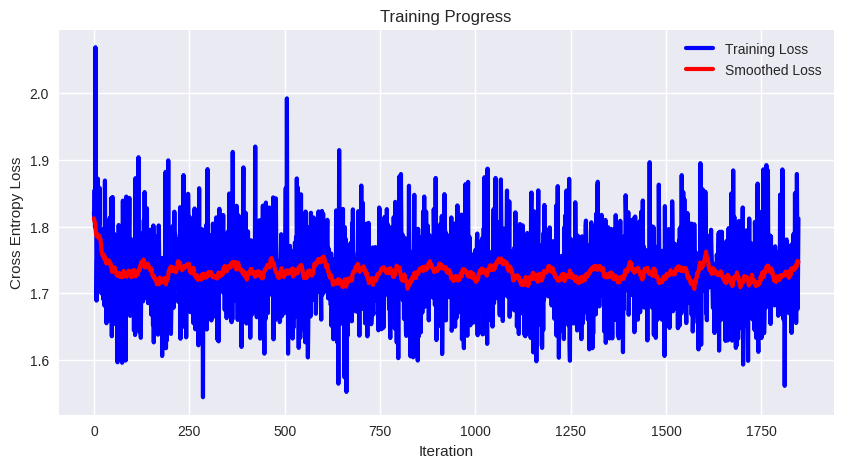

In [16]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,5)

smooth_loss = smooth(stats0["per_batch_loss"], 31)
ax.plot(stats0["per_batch_loss"], c="blue", label="Training Loss", linewidth=3)#, alpha=0.5)
ax.plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
ax.legend(loc="best")
ax.set_xlabel("Iteration")
ax.set_ylabel("Cross Entropy Loss")
ax.set_title("Training Progress")

plt.show()

Classification accuracy: 23.35%


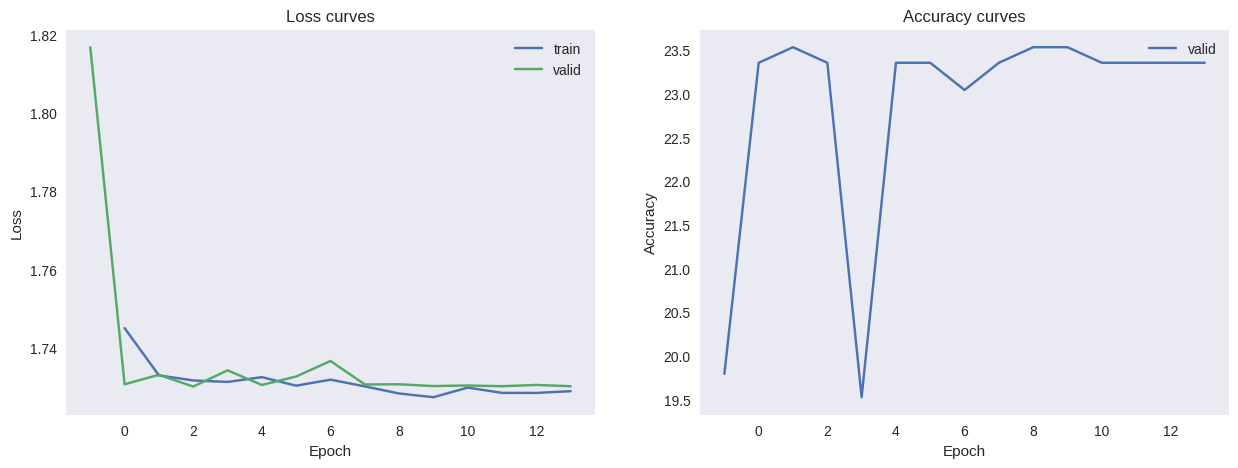

In [17]:
eval_plots(model0, val_loader, criterion, device, stats0)

0:boxing, 1:handclapping, 2:handwaving, 3:jogging, 4:running, 5:walking
Test accuracy: 23.35%
F1 Score: 0.23%


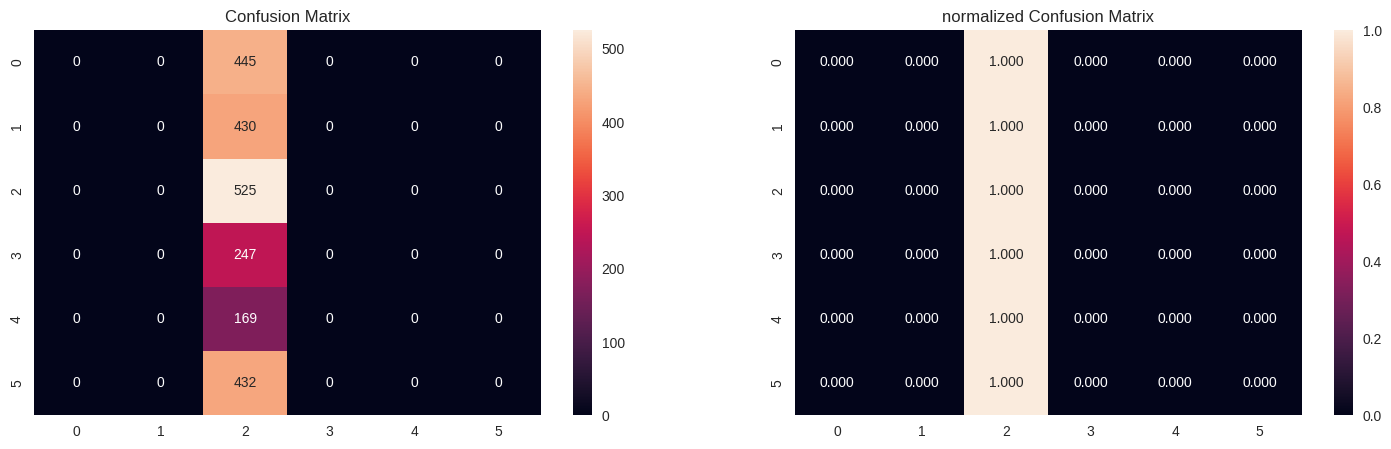

In [18]:
_, _, correct_labels, predicted_labels = eval_model_conf(model0, val_loader, criterion, device)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

# calculate absolute confusion matrix
confusion_matr = confusion_matrix(correct_labels, predicted_labels)#, labels=[0,1,2,3,4,5,6,7,8,9])
df_confusion = pd.DataFrame(confusion_matr, range(confusion_matr.shape[0]), range(confusion_matr.shape[0]))
# calculate confusion matric normalized in rows
confusion_matr_norm = confusion_matrix(correct_labels, predicted_labels, normalize = 'true') #, labels=[0,1,2,3,4,5,6,7,8,9]
df_confusion_norm = pd.DataFrame(confusion_matr_norm, range(confusion_matr_norm.shape[0]), range(confusion_matr_norm.shape[0]))

print('0:boxing, 1:handclapping, 2:handwaving, 3:jogging, 4:running, 5:walking')

fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,5)

ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("True Label")
ax[0].set_title("Confusion Matrix")
sn.heatmap(df_confusion, annot=True, annot_kws={"size": 10}, fmt="d", ax=ax[0]) 


ax[1].set_xlabel("Prediction")
ax[1].set_ylabel("True Label")
ax[1].set_title("normalized Confusion Matrix")
sn.heatmap(df_confusion_norm, annot=True, annot_kws={"size": 10}, fmt=".3f", ax=ax[1]) 

acc = 0
for i in range(confusion_matr.shape[0]):
  acc = acc + confusion_matr[i,i]
acc = acc/confusion_matr.sum()*100
print(f"Test accuracy: {round(acc,2)}%")

print(f"F1 Score: {round(f1_score(correct_labels, predicted_labels, average ='micro'),2)}%")

>The F1 score mirrors the resulting accuracy.

> The confusion matrix also looks similar to our convLSTM, with confusion between gestures using the arms and running, jogging, and walking. However here these gestures are confused much more often.